In [110]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.linalg
import scipy.io
import time
import scipy.signal as spsg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [294]:
class Data():
    def __init__(self,training_percentage):
        self.data = None
        self.training_data = None
        self.training_results = None
        self.test_data = None
        self.test_results = None
        self.spectral_bands = {
            'theta' : [4.,7.],
            'alpha' : [8.,15.],
            'beta'  : [15.,30.],
            'low gamma' : [30.,70.],
            'high gamma': [70.,100.],
            'low ripple': [100.,150.],
            'high ripple': [150.,200.],
            'low multi-unit': [200.,500.],
            'high multi-unit': [500.,1000.],
            'baseline': [4.,1000.]
        }
        self.training_percentage = training_percentage
        self.test_percentage = 100-training_percentage
        self.fs = 2048
        
    def import_data(self,file):
        """
            Loading data from MatLab, rounding to 4 decimals
        """
        self.data = scipy.io.loadmat(file)
        self.data = self.data['out'] 
        self.data = self.data.round(decimals=4)
        print(f'Total of {self.data.shape}' )  
        
    def build_training_matrix(self):
        """
            We build a training matrix from (128, 508, 35, 5) into (128, 76200), leaving 5 of the 35 trials for testing,
            for each one of the 5 states.
            
            order='F' means that data will be read/write with Fortran-like index order, due to data coming from MatLab
            
        """
        
        training_amount = int((self.data.shape[2]*self.training_percentage)/100)
        print(f'Amount of trials for training: {training_amount}')
        
        self.training_data = self.data[:,:,:training_amount,0]
        self.training_data = np.hstack((self.training_data,self.data[:,:,:training_amount,1],
                                        self.data[:,:,:training_amount,2],self.data[:,:,:training_amount,3],
                                        self.data[:,:,:training_amount,4]))

        self.training_data = self.training_data.reshape(self.training_data.shape[0],
                                                        self.training_data.shape[1]*self.training_data.shape[2], order='F')
        print(f'Training data shape {self.training_data.shape}')

    def build_training_results(self):
        if self.training_data is None:
            print("You first need to build your training matrix")
            return 1
        
        trial_size = self.data.shape[1] * 5
        
        s = 0
        s0 = self.data.shape[1]
        s1 = s0*2
        s2 = s1+s0
        s3 = s2+s0
        s4 = s3+s0
        
        self.training_results = np.zeros((5,self.training_data.shape[1]), dtype=float)
        
        while(s4 <= self.training_data.shape[1]):
            self.training_results[0,s:s0] = 0.9
            self.training_results[1,s0:s1] = 0.9
            self.training_results[2,s1:s2] = 0.9
            self.training_results[3,s2:s3] = 0.9
            self.training_results[4,s3:s4] = 0.9
            s, s0, s1, s2, s3, s4 = s+trial_size, s0+trial_size, s1+trial_size, s2+trial_size, s3+trial_size, s4+trial_size #moving to the next trial

        print(f'Training results shape {self.training_results.shape}')

        
    def build_test_matrix(self):
        """
            We build a training matrix from (128, 508, 35, 5) into (128, 76200), leaving 5 of the 35 trials for testing,
            for each one of the 5 states.
            
            order='F' means that data will be read/write with Fortran-like index order, due to data coming from MatLab
            
        """
        
        test_amount = int((self.data.shape[2]*self.training_percentage)/100)
        print(f'Amount of trials for testing: {self.data.shape[2]-test_amount}')
        
        self.test_data = self.data[:,:,test_amount:,0]
        self.test_data = np.hstack((self.test_data,self.data[:,:,test_amount:,1],
                                        self.data[:,:,test_amount:,2],self.data[:,:,test_amount:,3],
                                        self.data[:,:,test_amount:,4]))

        self.test_data = self.test_data.reshape(self.test_data.shape[0],
                                                        self.test_data.shape[1]*self.test_data.shape[2], order='F')
        print(f'Testing data shape {self.test_data.shape}')

    def build_test_results(self):
        if self.test_data is None:
            print("You first need to build your test matrix")
            return 1
        
        trial_size = self.data.shape[1] * 5
        
        s = 0
        s0 = self.data.shape[1]
        s1 = s0*2
        s2 = s1+s0
        s3 = s2+s0
        s4 = s3+s0
        
        self.test_results = np.zeros((5,self.test_data.shape[1]), dtype=float)
        
        while(s4 <= self.training_data.shape[1]):
            self.test_results[0,s:s0] = 0.9
            self.test_results[1,s0:s1] = 0.9
            self.test_results[2,s1:s2] = 0.9
            self.test_results[3,s2:s3] = 0.9
            self.test_results[4,s3:s4] = 0.9
            s, s0, s1, s2, s3, s4 = s+trial_size, s0+trial_size, s1+trial_size, s2+trial_size, s3+trial_size, s4+trial_size #moving to the next trial

        print(f'Training results shape {self.test_results.shape}')

        
    def shuffle_data(self,data,results):
        data_shuffle = np.vstack((data,results))
        np.random.shuffle(data_shuffle.T)
        
        data = data_shuffle[:128,:]
        
        results = data_shuffle[128:,:]
        
        print(f'Training data shape after shuffle {data.shape}')
        print(f'Training results shape after shuffle {results.shape}')
        return data,results
    
    def filter_data(self,data,range_filter):
        low_freq, high_freq = self.spectral_bands[range_filter]
        print(f'Band-pass filter between {low_freq} - {high_freq} Hz')
        
        low_freq, high_freq = low_freq/self.fs, high_freq/self.fs
        
        b,a = spsg.iirfilter(3, [low_freq,high_freq], btype='bandpass', ftype='butter')
        data = spsg.filtfilt(b, a, data, axis=1)
        
        return data


In [319]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None,
                 non_null_matrices = None): 
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
  
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))                
        self.u = None #input (matrix of size self.K x self.T) 
        self.u_test = None #input durint training (matrix of size self.K x t_dismiss+t_autonom) 
      

    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:] 
        
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, boundary_noise=None, t_autonom=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
        
        If test=True
            -Computes the predictions for the desired t_autonom
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            x_prev = self.trajectories[-1,:]
                       
        
        if test == False:
            for n in np.arange(self.T):
                x = np.tanh(np.dot(self.W_in,self.u[:,n])+np.dot(self.W,x_prev))
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:    
            trajectories = Network.trajectories[-1,:]
            for n in np.arange(t_autonom):
                x = np.tanh(np.dot(self.W_in, self.u_test[:,n])+np.dot(self.W,x_prev))
                trajectories = np.vstack((trajectories,x))
                x_prev = x
                
            y = np.tanh(self.regressor.predict(trajectories))
            return y


    
        """
            y = self.y_teach[:,-1].reshape(-1,1)
            for n in np.arange(t_autonom):
                x = np.tanh(np.dot(self.W_in, self.u_test[:,n])+np.dot(self.W,x_prev))
                x_prev = x
                y_next = np.tanh(self.regressor.predict(x.reshape(1,-1)))
                y_next = y_next.reshape(-1,1)
                y = np.hstack([y,y_next])   
            return y
        """

                
    def train_network(self, plot=False, noise=False, boundary_noise=0.001, ):
        """

        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        self.initial_state = np.ones(self.N)
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, boundary_noise=boundary_noise)
            
        regressor = LinearRegression()
        regressor.fit(self.dismiss_transient(self.trajectories[1:,:]), np.arctanh(self.dismiss_transient(self.y_teach.T)))

        self.regressor = regressor   
        
        return self   
    
    
    def test_network(self, data, t_autonom):
        """
        Args:
            -data
            -t_autonom, time we let the network freely run
        
        Returns:
            -Prediction
        """ 
        
        #Define u_test
        self.u_test = data                        
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_autonom=t_autonom)
        y = y[:,1:] 
        return y
            

In [320]:
d = Data(80)
d.import_data('dataSorted.mat')
d.build_training_matrix()
d.build_training_results()
print('--------------')
d.build_test_matrix()
d.build_test_results()

Total of (128, 508, 35, 5)
Amount of trials for training: 28
Training data shape (128, 71120)
Training results shape (5, 71120)
--------------
Amount of trials for testing: 7
Testing data shape (128, 17780)
Training results shape (5, 17780)


In [321]:
d.training_data = d.filter_data(d.training_data,'baseline')

Band-pass filter between 4.0 - 1000.0 Hz


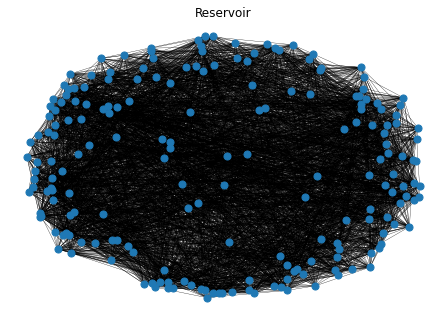

The reservoir has 200 nodes and 3801 edges


In [322]:
########################
# Initialize instance
########################
Network = Network()

########################
# Define the parameters
########################

Network.T = d.training_data.shape[1]
Network.n_min = 2540
Network.K = 128
Network.N = 200
Network.L = 5

Network.u = d.training_data
Network.y_teach = d.training_results

Network.initial_state = np.ones(Network.N)

########################
# Input Layer
########################

Network.W_in = np.zeros([Network.N,Network.K]) #input matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.K):
        p = np.random.uniform()
        if 0 <= p <= 0.1:
            Network.W_in[i,j] = np.random.uniform(-1., 1.)            
            
        else:
            Network.W_in[i,j] = 0
            

########################
# Reservoir Layer
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0 <= p <= 0.1:
            Network.W[i,j] = np.random.normal(loc=0, scale=1, size=1)[0]         
            
        else:
            Network.W[i,j] = 0
            
            

G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))            


In [323]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 4.793339424745973
The maximum singular value (in module) is 9.788221429754604


In [324]:
alpha = 0.22/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [325]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 0.21999999999999983
The maximum singular value (in module) is 0.44925020402871485


Since $\sigma_{max}<1$, the existence of echo states is guaranteed.

In [326]:
start = time.time()
Network.train_network(plot=False, noise=False, boundary_noise=0.001) 
print(Network.trajectories.shape)#columns -> nodes; rows -> time steps
end = time.time()
print(f'Total of {end - start} seconds')

(71121, 200)
Total of 786.118754863739 seconds


In [327]:
y=Network.test_network(Network.u ,t_autonom=d.training_data.shape[1])

In [328]:
acc = 0

for i in range(y.shape[1]):
    tmp = [y[0,i],y[1,i],y[2,i],y[3,i],y[4,i]]
    
    res = tmp.index(max(tmp))

    
    tmp2 = [d.training_results[0,i],d.training_results[1,i],d.training_results[2,i],d.training_results[3,i],d.training_results[4,i]]
    res2 = tmp2.index(max(tmp2))
    
    if res == res2:
        acc += 1
        
print(acc/y.shape[1])

0.75


In [329]:
y=Network.test_network(d.test_data,t_autonom=d.test_data.shape[1])

In [330]:
acc = 0

for i in range(y.shape[1]):
    tmp = [y[0,i],y[1,i],y[2,i],y[3,i],y[4,i]]
    
    res = tmp.index(max(tmp))

    
    tmp2 = [d.training_results[0,i],d.training_results[1,i],d.training_results[2,i],d.training_results[3,i],d.training_results[4,i]]
    res2 = tmp2.index(max(tmp2))
    
    if res == res2:
        acc += 1
        
print(acc/y.shape[1])

0.75
